# Init

In [1]:
import configparser, os, sys

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import kaiser

config = "bruz"
if config == "ur1":
    sys.path.insert(0, "../")
    siepelDir = "C:/Users/pleroy/Documents/CAMILL/SER/WR15_v2"
elif config == "bruz":
    sys.path.insert(0, "/home/pleroy/DEV/DIADEM")
    siepelDir = "/home/pleroy/DATA/CAMILL/WR15_v2"

import toolsdiadem.tools as dia
import toolsdiadem.ser as ser
from toolsdiadem.ConfigSer import ConfigSer
from toolsdiadem.ConfigSer2 import ConfigSer2
from toolsdiadem.Gate import Gate

In [2]:
#%matplotlib qt5
%load_ext autoreload
%autoreload 2

In [3]:
cmap='jet'
conf = ConfigSer2(os.path.join(siepelDir, "wr10.ini"))
conf.printConfig()
dataShape = (conf.sup.nb_elev, conf.sup.nb_freq)

/home/pleroy/DATA/CAMILL/WR15_v2/wr10.ini
base_path (path to the ini file): /home/pleroy/DATA/CAMILL/WR15_v2
out_path (for the processing outputs): /home/pleroy/DATA/CAMILL/WR15_v2/processing/wr10
gateWidth 500.0
gateCenter 6450.0
centerFreq 92.5
bandWidth 17.4
idxElevation 21
vmin -90.0
vmax -40.0

SUPPORT
nb_elev 41
nb_freq 2801
nb_ssb 4
el0 0.65
az0 -0.44

REFERENCE
nb_elev 41
nb_freq 2801
nb_ssb 4
el0 0.275
az0 -0.44


## Fond de chambre

In [5]:
file_f2c = os.path.join(conf.out_path, "data", "S11_fond_de_chambre.txt")
#file_f2c = os.path.join(conf.out_path, "data", "S11_fond_de_chambre_16_Aug_15h44.txt")
tmp = np.loadtxt(file_f2c, skiprows=1)
print(file_f2c)
S11_f2c = tmp[:,1] + 1j * tmp[:,2]

/home/pleroy/DATA/CAMILL/WR15_v2/processing/wr10/data/S11_fond_de_chambre.txt


## Probe

In [6]:
tmp = np.loadtxt(os.path.join(conf.out_path, "data", "S11_probe_interpolated.txt"))
S11_probe = tmp[:,1] + 1j * tmp[:,2]
freq_probe = tmp[:,0]

## Plaque de référence

In [7]:
tmp = np.loadtxt(os.path.join(conf.out_path, "data", "S11_plaque_ref_from_scan.txt"), skiprows=1)
S11_reference = tmp[:,1] + 1j * tmp[:,2]
freq_all = tmp[:,0]
d = np.linspace(0, 300 / (freq_all[1] - freq_all[0]), conf.ref.nb_freq) * 0.5

Text(0.5, 1.0, 'time domain, width 500 center 6450')

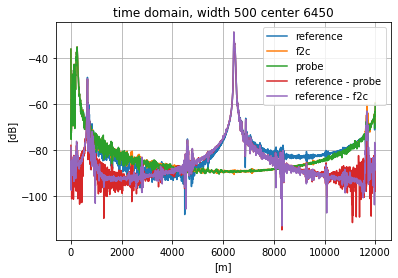

In [8]:
fig, ax = plt.subplots(1,1)
ax.plot(d, ser.dB(np.fft.ifft(S11_reference)), label="reference")
ax.plot(d, ser.dB(np.fft.ifft(S11_f2c)), label="f2c")
ax.plot(d, ser.dB(np.fft.ifft(S11_probe)), label="probe")
ax.plot(d, ser.dB(np.fft.ifft(S11_reference - S11_probe)), label="reference - probe")
ax.plot(d, ser.dB(np.fft.ifft(S11_reference - S11_f2c)), label="reference - f2c")
ax.grid()
ax.legend()
ax.set_xlabel("[m]")
ax.set_ylabel("[dB]")
ax.set_title(f"time domain, width {conf.gateWidth:.0f} center {conf.gateCenter:.0f}")

# Réflectivité
ref: ser4siepel_multiband_scan_elev_Reflectivite.sce

In [9]:
myGate = Gate(d, width=conf.gateWidth, center=conf.gateCenter)
gate = myGate.gateLLC

gateSize 233


## Lecture des données

In [10]:
#date, absorbant = "20200715", "039_W"
date, absorbant = "20200715", "040_W_v2"
dir_abs = f"{conf.base_path}/{date}/{absorbant}"
freq_abs, S11_abs = ser.getData_ssb(conf.sup.nb_elev, conf.sup.nb_freq, conf.sup.nb_ssb, dir_abs, tag="WR10_")

## Calcul de la réflectivité

In [11]:
reflectivite = ser.getReflectivite(S11_abs, S11_reference, S11_f2c, gate)

In [12]:
S11_plaque_ref_tg = np.fft.fft(np.fft.ifft(S11_reference - S11_f2c) * gate)
S11_minus_fdc = S11_abs - S11_f2c
s11_minus_fdc_td = np.fft.ifft(S11_minus_fdc, axis=1)
s11_minus_fdc_tg = s11_minus_fdc_td * gate
S11_minus_fdc_tg = np.fft.fft(s11_minus_fdc_tg, axis=1)
reflectivite = S11_minus_fdc_tg / S11_plaque_ref_tg

s11_td = np.fft.ifft(S11_abs, axis=1)
s11_td_plaqueRef = np.fft.ifft(S11_reference)

Text(0.5, 1.0, 'élévation 0.65°')

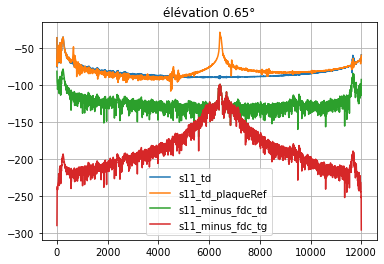

In [13]:
idx = 20
plt.figure()
plt.plot(d, ser.dB(s11_td[idx, :]), label="s11_td")
plt.plot(d, ser.dB(s11_td_plaqueRef), label="s11_td_plaqueRef")
plt.plot(d, ser.dB(s11_minus_fdc_td[idx, :]), label="s11_minus_fdc_td")
plt.plot(d, ser.dB(s11_minus_fdc_tg[idx, :]), label="s11_minus_fdc_tg")
plt.legend()
plt.grid()
plt.title(f"élévation {conf.sup.elevation[idx]}°")

valMax = -56.18 valMin = -90.00


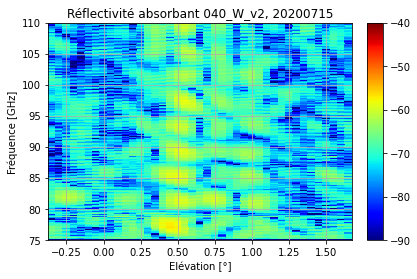

In [16]:
toPlot = np.zeros(dataShape)
gatebis  = 0.0 * gate
gatebis[np.where(np.abs(freq_abs - conf.centerFreq) < conf.bandWidth)] = 1.0
toPlot = 20 * np.log10(1e-12 + np.abs(reflectivite * gatebis))

valMin = -90
toPlot = 0.5 * (np.abs(toPlot - valMin) + toPlot - valMin) + valMin
valMax = np.amax(toPlot)
valMin = np.amin(toPlot)
print(f"valMax = {valMax:.2f} valMin = {valMin:.2f}")

fig, ax = plt.subplots(1, 1)
im = plt.pcolormesh(conf.sup.elevation, np.flip(freq_abs), np.rot90(toPlot), cmap=cmap, vmin=conf.vmin, vmax=conf.vmax, shading='auto')
title = f"Réflectivité absorbant {absorbant}, {date}"
ax.set_title(title)
ax.set_xlabel("Elévation [°]")
ax.set_ylabel("Fréquence [GHz]")
dia.addColorBar(im, ax, aspect='auto')

In [17]:
descriptor = f"{absorbant}_{date}"
filename = f"{conf.out_path}/data/reflectivite_{descriptor}"
np.save(filename, reflectivite)

Text(0, 0.5, 'réflectivité [dB]')

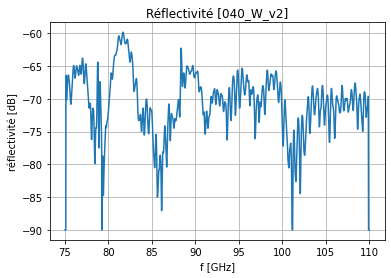

In [18]:
fig, ax = plt.subplots(1,1)
ax.plot(freq_abs, toPlot[conf.idxElevation, :])
ax.grid()
title = f"Réflectivité [{absorbant}]"
ax.set_title(title)
ax.set_xlabel("f [GHz]")
ax.set_ylabel("réflectivité [dB]")

In [19]:
np.save( f"{conf.out_path}/data/freq_WR10", freq_abs )
np.save( f"{conf.out_path}/data/elevation_WR10", conf.sup.elevation )

# Tous les absorbants

In [20]:
idx = np.where(np.abs(freq_abs - conf.centerFreq) < conf.bandWidth)
idxAlt = np.where(np.abs(freq_abs - conf.centerFreq) >= conf.bandWidth)

dic_stats = {}
toPlot = np.zeros(dataShape)

gate = myGate.gateLLC
#date = "20200716" # 09, 15, 16
date = "20200818" # 18

for absorbant in conf.dic_dir[date]:
    
    seq = 0
    flag_gate = 1
    data_dir = f"{conf.base_path}/{date}/{absorbant}"
    descriptor = f"{absorbant}_{date}"
    
    print(f"======= {descriptor} =======")
    
    freq_abs, S11 = ser.getData_ssb(conf.sup.nb_elev, conf.sup.nb_freq, conf.sup.nb_ssb, data_dir, tag="WR10_")
            
    #=============
    # REFLECTIVITE
    reflectivite = ser.getReflectivite(S11, S11_reference, S11_f2c, gate)
    np.save( 
        f"{conf.out_path}/data/reflectivite/{descriptor}",
        reflectivite 
    )
    
    # drop lower and higher frequencies values
    toPlot[:,idx] = 20 * np.log10(1e-12 + np.abs( reflectivite[:,idx]))
    toPlot[:,idxAlt] = -90

    fig, ax = plt.subplots( 1, 1 )
    im = ax.pcolormesh(conf.sup.elevation, np.flip( freq_abs ), np.rot90(toPlot), cmap=cmap, vmin=conf.vmin, vmax=conf.vmax, shading='auto')
    title = f"Réflectivité [{descriptor}]"
    ax.set_title(title)
    ax.set_xlabel( "Elévation [°]" )
    ax.set_ylabel( "Fréquence [GHz]" )
    dia.addColorBar(  im, ax, aspect='auto' )
    fig.savefig(
        f"{conf.out_path}/plot/reflectivite/reflectivite_{descriptor}.png"
    )

    #======
    # STATS
    valMax = np.amax( toPlot )
    valMin = np.amin( toPlot )

    absReflectivite   = np.abs( reflectivite )
    reflectiviteMoy   = np.average( absReflectivite[:,idx] )
    reflectiviteSigma = np.std( absReflectivite[:,idx] )

    reflectiviteMoy_dB   = 20 * np.log10( np.abs( reflectiviteMoy ) )
    reflectiviteSigma_dB = 20 * np.log10( np.abs( reflectiviteSigma ) )
        
    #==========
    # HISTOGRAM
    fig, ax = plt.subplots(1,1)
    ax.hist((absReflectivite[:,idx]).flatten(), 50, label="histogramme (valeurs linéaires)")
    ax.grid()
    title = f"Réflectivité, histogramme [{descriptor}]"
    ax.set_title(title)
    ax.legend()
    fig.savefig(
        f"{conf.out_path}/plot/hist/hist_{descriptor}.png"
    )
        
    #===========
    # PLOT WRT F
    fig, ax = plt.subplots(1,1)
    ax.plot( freq_abs, toPlot[conf.idxElevation, : ] )
    ax.grid()
    title = f"Réflectivité [{descriptor}]"
    ax.set_title(title)
    ax.set_xlabel("f [GHz]")
    ax.set_ylabel("réflectivité [dB]")
    fig.savefig(
        f"{conf.out_path}/plot/reflectivite_vs_f/reflectivite_vs_f_{descriptor}.png"
    )
    
    plt.close("all")
    
    dic_stats[f"{descriptor}"] = (valMax, valMin, reflectiviteMoy, reflectiviteSigma, reflectiviteMoy_dB)

======= 060_AC_20200818 =======
======= 061_AD_20200818 =======


In [21]:
for absorbant in dic_stats.keys():
    stats = dic_stats[absorbant]
    print(f"{absorbant} {stats[0]:.2f} {stats[1]:.2f} {stats[2]:.6f} {stats[3]:.6f} {stats[4]:.2f}")

060_AC_20200818 -36.50 -105.53 0.002408 0.002085 -52.37
061_AD_20200818 -35.40 -118.04 0.003083 0.003071 -50.22


# Remove all

In [ ]:
for root, dirs, files in os.walk(f"{base_path}/processing"):
    for f in files:
        if f.endswith(".png") or f.endswith(".npy"):
            os.remove(os.path.join(root, f)) # remove or unlink does the same

In [ ]:
os.walk(f"{base_path}/processing")